In [ ]:
!git clone https://github.com/LeoisWTT/PHYS3151-Machine-Learning-in-Physics-2023


## 2D Ising model phases classification

In [88]:
import numpy as np
import pandas as pd
import time
from csv import reader

In [264]:
epochs = 1000
mini_batch_size = 20
eta = 2

In [265]:
class Network(object):
    # the list ''sizes'' contains the number of neurons in the respective layers of the network.
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.biases = [np.random.rand(y, 1) for y in sizes[1:]]
        self.weights = [np.random.rand(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    # return the output of the network if "a" is input.
    def forwardprop(self, a):
        # list to store all the activations, layer by layer
        self.activations = [a]
        self.zs = []  # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, a) + b
            self.zs.append(z)
            a = sigmoid(z)
            self.activations.append(a)
        self.predict = np.where(self.activations[-1] > 0.5, 1, 0)

    # Train the neural network using mini-batch gradient descent.
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data):
        X, Y = training_data
        n = X.shape[1]
        cost = []
        accuracy_train = []
        accuracy_test = []

        I = int(epochs/3)
        for j in range(epochs):
            # Shuffle the data
            X, Y = shuffle(X, Y, n)

            if j+1 % I == 0:
                eta /= 1.5

            for k in range(0, n, mini_batch_size):
                self.update(X[:, k:k+mini_batch_size],
                            Y[:, k:k+mini_batch_size], eta)
            accuracy_train.append(self.evaluate((X, Y)))
            cost.append(self.quadratic_cost(X, Y))
            accuracy_test.append(self.evaluate(test_data))

        return cost, accuracy_train, accuracy_test

    # update the network's weights and biases by applying gradient descent
    # using backward propogation to a single mini batch.
    def update(self, x, y, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        m = x.shape[1]

        # forward propogation
        self.forwardprop(x)

        # backward propogation
        delta = (self.activations[-1]-y)*sigmoid_prime(self.zs[-1])
        nabla_b[-1] = np.sum(delta, axis=1, keepdims=True)
        nabla_w[-1] = np.dot(delta, self.activations[-2].T)
        for l in range(2, self.num_layers):
            delta = np.dot(self.weights[-l+1].T,
                           delta) * sigmoid_prime(self.zs[-l])
            nabla_b[-l] = np.sum(delta, axis=1, keepdims=True)
            nabla_w[-l] = np.dot(delta, self.activations[-l-1].T)

        # update the weights and biases
        self.weights = [w-(eta/m)*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/m)*nb for b, nb in zip(self.biases, nabla_b)]

    def evaluate(self, data):
        x, y = data
        self.forwardprop(x)
        return 100-np.sum(abs(self.predict-y))/y.shape[1]*100

    def quadratic_cost(self, x, y):
        return np.sum((self.activations[-1]-y)**2)/y.shape[1]


# Miscellaneous functions
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))


def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))


def shuffle(x, y, n):
    permutation = list(np.random.permutation(n))
    x = x[:, permutation]
    y = y[:, permutation].reshape((1, n))
    return x, y


def training(net):
    startTime = time.time()
    cost, train, test = net.SGD(
        training_data, epochs, mini_batch_size, eta, test_data)
    executionTime = (time.time() - startTime)
    return cost, train, test, executionTime


### 1. Data Processing

In [266]:
df1 = pd.read_csv(
    "./PHYS3151-Machine-Learning-in-Physics-2023/feedforward-neural-network/Ising/Ising_conf.csv", header=None, sep=",")
df2 = pd.read_csv(
    "./PHYS3151-Machine-Learning-in-Physics-2023/feedforward-neural-network/Ising/Ising_temp.csv", header=None, sep=",").rename(columns={0: "T"})

# Standardize the data
df1 = (df1 - np.mean(df1, axis=0)) / np.std(df1, axis=0, ddof=0)

x = df1.to_numpy().T
y = df2.to_numpy().T
n = x.shape[1]

# Shuffle the data
X, Y = shuffle(x, y, n)

# Construct the expected output list Y
Y = np.where(Y > 2.269, 0, 1)

training_data = (X[:, :int(0.2*n)], Y[:, :int(0.2*n)])
test_data = (X[:, int(0.2*n):], Y[:, int(0.2*n):])


### 2. Model Construction

In [267]:
net1 = Network([100,2,1])
net2 = Network([100,2,2,1])

### 3. Model Training

In [268]:
costs = []
accuracies = []
for i, net in enumerate([net1, net2]):
    cost, train, test, executionTime = training(net)
    costs.append(cost)
    accuracies.append([train, test])
    print('Training time for network_{}: {:.3f}s'.format(i+1, executionTime))


Training time for network_0: 3.932s
Training time for network_1: 4.856s


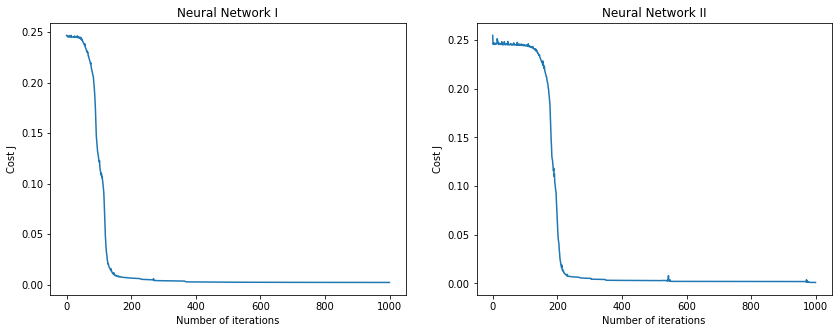

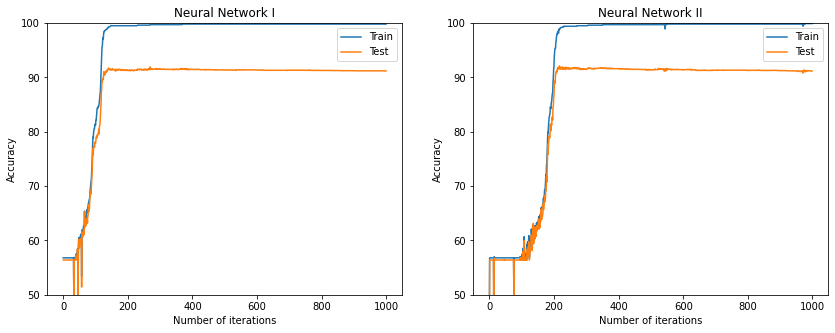

In [269]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs = axs.flat
titles = ['Neural Network I', 'Neural Network II']
for ax, cost, title in zip(axs, costs, titles):
    ax.plot(cost)
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('Cost J')
    ax.set_title(title)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs = axs.flat
for ax, accuracy, title in zip(axs, accuracies, titles):
    ax.plot(accuracy[0], label='Train')
    ax.plot(accuracy[1], label='Test')
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.set_ylim(50, 100)
    ax.set_title(title)


### 4. Model Evaluation

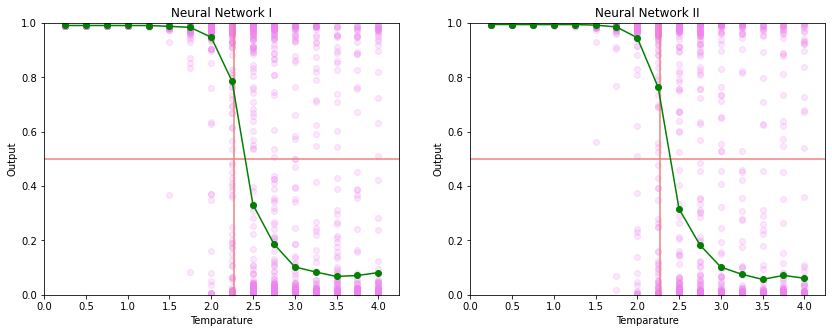

In [270]:
df = pd.concat([df1, df2], axis=1)
df = df.sort_values(by='T')

X = df.iloc[:, :-1].to_numpy().T
Y = df.iloc[:, -1:].to_numpy().T

net1.forwardprop(X)
net2.forwardprop(X)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs = axs.flat
for ax, output, title in zip(axs, [net1.activations[-1], net2.activations[-1]], titles):
    a = pd.DataFrame(np.vstack((Y, output)).T, columns=['T', 'output'])
    a = a.groupby(['T'])['output'].mean().to_numpy()
    ax.vlines(2.269, 0, 1, colors='lightcoral')
    ax.hlines(0.5, 0, 4.25, colors='lightcoral')
    ax.scatter(Y, output, alpha=0.2, c='violet')
    ax.plot([i for i in np.arange(0.25, 4.25, 0.25)], a, c='g', marker='o')
    ax.set_xlabel('Temparature')
    ax.set_ylabel('Output')
    ax.set_xlim(0, 4.25)
    ax.set_ylim(0, 1)
    ax.set_title(title)


### 5. Discussion

Both models show satisfactory performance on testing data, but there are some notable differences. The model with only one hidden layer exhibits a faster decrease in cost function during training compared to the model with two hidden layers. This is because neural networks with more hidden layers have a larger optimization space, leading to slower convergence at the beginning of training. However, it's essential to note that having too few hidden layers may result in the model being unable to capture complex patterns in the data. Fortunately, the model with one hidden layer appears to be able to capture the necessary patterns in our case, negating this issue.

Additionally, the model with one hidden layer takes less time for training due to fewer parameters to optimize and one fewer step while forward and back-propagating. Furthermore, having a smaller number of parameters may be beneficial in terms of memory usage.

Overall, these observations suggest that the model with one hidden layer is sufficient for classifying the Ising model phases.